In [1]:
import numpy as np
import scipy as sc
import sympy as sp
#from openseespy import opensees as ops
import matplotlib.pyplot as plt

In [2]:
def truss_stiffness_matrix(nodes, elements, EA, supports):
    """
    Assemble the global stiffness matrix for a 2D truss using sympy.

    Parameters:
        nodes (dict): Dictionary of node coordinates {node_id: (x, y)}
        elements (list): List of tuples (node1, node2) defining element connectivity
        A (dict): Dictionary of cross-sectional areas {element_id: A_value}
        E (dict): Dictionary of Young's modulus values {element_id: E_value}

    Returns:
        sympy.Matrix: Global stiffness matrix
    """
    num_nodes = len(nodes)
    dof = 2 * num_nodes  # Degrees of freedom (2 per node)
    K_global = sp.zeros(dof, dof)

    for i, (n1, n2) in enumerate(elements):
        x1, y1 = nodes[n1]
        x2, y2 = nodes[n2]
        L = sp.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)  # Element length
        c = (x2 - x1) / L  # Cosine of angle
        s = (y2 - y1) / L  # Sine of angle

        # Stiffness matrix for an element in local coordinates
        k_local = (EA[i] / L) * sp.Matrix([
            [c ** 2, c * s, -c ** 2, -c * s],
            [c * s, s ** 2, -c * s, -s ** 2],
            [-c ** 2, -c * s, c ** 2, c * s],
            [-c * s, -s ** 2, c * s, s ** 2]
        ])

        # Global DOF indices
        dof_indices = [2 * n1, 2 * n1 + 1, 2 * n2, 2 * n2 + 1]

        # Assemble into global stiffness matrix
        for r in range(4):
            for c in range(4):
                K_global[dof_indices[r], dof_indices[c]] += k_local[r, c]

        for i in supports:
            for j in range(K_global.shape[0]):
                K_global[i, j] = 0.
                K_global[j, i] = 0.
            K_global[i, i] = 1

    return K_global


def analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A_list, E_list):
    """
    Parameters:
        nodes: np.array of shape (n_nodes, 3)
        connectivity_matrix: np.array of shape (n_elements, 2)
        supports: dict {node_index: (fix_x, fix_y)}
        loads: dict {node_index: [Fx, Fy]}
        A_list: list of cross-sectional areas (length = n_elements)
        E_list: list of Young's moduli (length = n_elements)

    Returns:
        displacements: dict {node_index: [ux, uy]}
    """

    ops.wipe()
    ops.model('basic', '-ndm', 2, '-ndf', 2)

    # Create nodes
    for i, (x, y, _) in enumerate(nodes):
        ops.node(i, x, y)

    # Supports
    for node_id, (fix_x, fix_y) in supports.items():
        ops.fix(node_id, int(fix_x), int(fix_y))

    # Define elements and materials
    for i, (ni, nj) in enumerate(connectivity_matrix):
        E = E_list[i]
        A = A_list[i]
        ops.uniaxialMaterial("Elastic", i, E)
        ops.element("truss", i, int(ni), int(nj), A, i)

    # Apply loads
    ops.timeSeries("Linear", 1)
    ops.pattern("Plain", 1, 1)
    for node_id, (Fx, Fy) in loads.items():
        ops.load(node_id, Fx, Fy)

    # Static analysis
    ops.system("SparseGeneral")
    ops.numberer("RCM")
    ops.constraints("Plain")
    ops.integrator("LoadControl", 1.0)
    ops.algorithm("Linear")
    ops.analysis("Static")
    ops.analyze(1)

    # Get displacements
    displacements = np.array([
        [ops.nodeDisp(i, 1), ops.nodeDisp(i, 2)]
        for i in range(len(nodes))
    ])

    forces = np.array([ops.eleResponse(i, 'axialForce')[0] for i in range(len(connectivity_matrix))])

    return displacements, forces

In [3]:
nodes = np.array([(0, 0, 0), (5, 0, 0), (10, 0, 0), (5, 5, 0)], dtype=float)
supports = {0: (True, True), 2: (False, True)}
connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
loads = {1: [0., -1000.e3],
         2: [1000.e3, 0.],
         3: [-1000.e3, -1000.e3]}

supports_dof = [2 * k + i for k, v in supports.items() for i, b in enumerate(v) if b]
mask = [i for i in range(2*len(nodes)) if i not in supports_dof]

q_ = np.zeros(2 * len(nodes))
for k, (x, y) in loads.items():
    q_[2 * k] += x
    q_[2 * k + 1] += y

A = np.array([.0025, 0.005, 0.01, 0.0075, 0.02])
E = np.array([210.e9, 210.e9, 70.e9, 70.e9, 150.e9])

target = E * A

K_ = truss_stiffness_matrix(
    nodes[:, :2], connectivity_matrix, [sp.Symbol(f'EA{i}', real=True, positive=True) for i in range(5)],
    supports_dof
)
Kf = sp.lambdify(sorted(K_.free_symbols, key=lambda x: str(x)), K_, 'numpy')

In [3]:
nodes = np.array([(0, 0, 0), (5, 0, 0), (10, 0, 0), (5, 5, 0)], dtype=float)
supports = {0: (True, True), 2: (False, True)}
connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
loads = {1: [0., -1000.e3],
         2: [1000.e3, 0.],
         3: [-1000.e3, -1000.e3]}

supports_dof = [2 * k + i for k, v in supports.items() for i, b in enumerate(v) if b]
mask = [i for i in range(2*len(nodes)) if i not in supports_dof]

q_ = np.zeros(2 * len(nodes))
for k, (x, y) in loads.items():
    q_[2 * k] += x
    q_[2 * k + 1] += y

A = np.array([.0025, 0.005, 0.01, 0.0075, 0.02])
E = np.array([210.e9, 210.e9, 70.e9, 70.e9, 150.e9])

target = E * A

K_ = truss_stiffness_matrix(
    nodes[:, :2], connectivity_matrix, [sp.Symbol(f'EA{i}', real=True, positive=True) for i in range(5)],
    supports_dof
)

Kf = sp.lambdify(sorted(K_.free_symbols, key=lambda x: str(x)), K_, 'numpy')

u_, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)

In [4]:
def mape(x_pred, x):
    return np.mean(np.abs((x_pred-x)/x))

def test(noise):
    u = u_ * np.random.normal(1, noise / 2, u_.shape)
    u = u.reshape(-1)[mask]
    u = sp.Matrix(u.T)

    q = q_ * np.random.normal(1, noise / 2, q_.shape)
    q = q.reshape(-1)[mask]
    q = sp.Matrix(q.T)

    K = K_.copy()
    K = K[mask,:][:, mask]

    eqs = K @ u - q

    vars = sorted(list(K.free_symbols), key=lambda s: str(s))
    rows = []

    for eq in eqs:
        coeffs = [eq.coeff(v) for v in vars]
        const = -eq.subs({v: 0 for v in vars})  # move constant to the right-hand side
        rows.append(coeffs + [const])

    augmented = sp.Matrix(rows)

    rref_matrix, pivots = augmented.rref()
    EA_pred = sp.matrix2numpy(rref_matrix.evalf()[:,-1])

    return EA_pred

noise_values = np.linspace(0, .1, 21)
mape_hist = []
found = False

np.random.seed(326)
for noise in noise_values:
    mape_hist_trial = []
    for i in range(10):
        pred = test(noise).reshape(-1)
        m = mape(pred, target.T)
        mape_hist_trial.append(m)
    mape_hist.append(mape_hist_trial)

mape_hist = np.array(mape_hist)

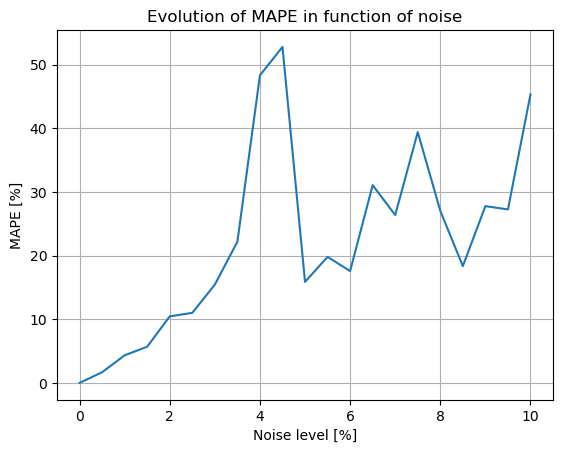

In [12]:
fig, ax = plt.subplots()
ax.set_title("Evolution of MAPE in function of noise")
ax.plot(100*noise_values, 100*mape_hist.mean(axis=1))
ax.set_xlabel('Noise level [%]')
ax.set_ylabel('MAPE [%]')
ax.grid(True)
fig.savefig("03_truss_example_noise_mape.pdf")

In [8]:
np.savetxt("analytical_mean_mape.dat", mape_hist.mean(axis=1), delimiter='')

In [83]:
print(j-1)

72


In [67]:
# 5 17 np.linspace(0, .1, 11)
# 326 np.linspace(0, .1, 21) 10